In [1]:
import os
import glob
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from sentence_transformers import SentenceTransformer, util

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import torch
from lavis.models import load_model_and_preprocess

In [3]:
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# Flickr 8k images
img_folder = 'photos/'
caps_folder = 'captions/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)

    if not os.path.exists('Flickr8k_Dataset.zip'):   #Download dataset if does not exist
        util.http_get('https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip', 'Flickr8k_Dataset.zip')
        util.http_get('https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip', 'Flickr8k_text.zip')

    for folder, file in [(img_folder, 'Flickr8k_Dataset.zip'), (caps_folder, 'Flickr8k_text.zip')]:
        with zipfile.ZipFile(file, 'r') as zf:
            for member in tqdm(zf.infolist(), desc='Extracting'):
                zf.extract(member, folder)
images = list(glob.glob('photos/Flicker8k_Dataset/*.jpg'))

# Prepare dataframe
captions = pd.read_csv("captions/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
captions.img_id = captions.apply(lambda row: "photos/Flicker8k_Dataset/" + row.img_id.split(".jpg")[0] + ".jpg", 1)
captions = captions.groupby(["img_id"])["img_caption"].apply(','.join).reset_index()
captions = pd.merge(captions, pd.Series(images, name="img_id"), on="img_id")

# Extract images together with their documents/captions
images = captions.img_id.to_list()
docs = captions.img_caption.to_list()

  0%|          | 0.00/1.12G [00:00<?, ?B/s]

  0%|          | 0.00/2.34M [00:00<?, ?B/s]

Extracting: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 250.17it/s]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_feature_extractor", model_type="base", is_eval=True, device=device)

In [7]:
embeddings = []
for i in tqdm(range(len(images))):
    raw_image = vis_processors["eval"](Image.open(images[i]).convert("RGB")).unsqueeze(0).to(device)
    text_input = txt_processors["eval"](docs[i])
    sample = {'image': raw_image, 
              'text_input': [text_input]}
    
    features_image = model.extract_features(sample, mode="image")
#     features_text = model.extract_features(sample, mode="text")
#     features_multimodal = model.extract_features(sample)
    img_emb = features_image.image_embeds[:,0,:].cpu().numpy()
#     img_emb = features_multimodal.multimodal_embeds[:,0,:].cpu().numpy()
    embeddings.extend(img_emb.tolist())


100%|██████████████████████████████████████████████████████████████████████████████████| 8091/8091 [02:13<00:00, 60.46it/s]


In [9]:
embeddings = np.array(embeddings)

In [10]:
vectorizer_model = CountVectorizer(stop_words="english")
topic_model_a = BERTopic(vectorizer_model=vectorizer_model)
topics_a, probs_a = topic_model_a.fit_transform(docs, embeddings)
captions["Topic"] = topics_a

In [11]:
vectorizer_model = CountVectorizer(stop_words="english")
topic_model_b = BERTopic(vectorizer_model=vectorizer_model)
topics_b, probs_b = topic_model_b.fit_transform(docs)
captions["Topic_text"] = topics_b

In [28]:
# from bertopic.representation import MaximalMarginalRelevance
# representation_model = MaximalMarginalRelevance(diversity=0.5)
# cluster_seed = ['westbound', 'eastbound', 'side', 'pedestrian', 'east-west', 'southbound', 'northbound', 'north-south', 'west', 'directional', 'south']

# vectorizer_model = CountVectorizer(stop_words="english")
# topic_model_txt_g = BERTopic(vectorizer_model=vectorizer_model, 
#                        representation_model=representation_model, 
#                seed_topic_list=[cluster_seed], nr_topics='auto')

# topics_g, probs_g = topic_model_txt_g.fit_transform(docs)
# sim_matrix = cosine_similarity(topic_model_a.c_tf_idf_, topic_model_txt_g.c_tf_idf_)

In [35]:
topic_model_a.c_tf_idf_[0][0]

<1x8006 sparse matrix of type '<class 'numpy.float64'>'
	with 4944 stored elements in Compressed Sparse Row format>

In [12]:
topic_model_a.c_tf_idf_.shape

(94, 8006)

In [13]:
topic_model_b.c_tf_idf_.shape

(161, 8006)

In [33]:
sim_matrix = cosine_similarity(topic_model_a.c_tf_idf_, topic_model_b.c_tf_idf_)


In [34]:
sim_matrix.shape

(94, 161)

In [127]:
captions

,img_id,img_caption,Topic,Topic_text
0,photos/Flicker8k_Dataset/1000268201_693b08cb0e...,A child in a pink dress be climb up a set of s...,-1,-1
1,photos/Flicker8k_Dataset/1001773457_577c3a7d70...,"A black dog and a spotted dog be fight,A black...",2,47
2,photos/Flicker8k_Dataset/1002674143_1b742ab4b8...,A little girl cover in paint sit in front of a...,-1,-1
3,photos/Flicker8k_Dataset/1003163366_44323f5815...,A man lay on a bench while his dog sit by him ...,-1,12
4,photos/Flicker8k_Dataset/1007129816_e794419615...,"A man in an orange hat star at something .,A m...",13,-1
...,...,...,...,...
8086,photos/Flicker8k_Dataset/990890291_afc72be141.jpg,A man do a wheelie on his bicycle on a sidewal...,-1,145
8087,photos/Flicker8k_Dataset/99171998_7cc800ceef.jpg,"A group be sit around a snowy crevasse .,A gro...",-1,2
8088,photos/Flicker8k_Dataset/99679241_adc853a5c0.jpg,A gray bird stand majestically on a beach whil...,1,21
8089,photos/Flicker8k_Dataset/997338199_7343367d7f.jpg,"A person stand near golden wall .,a woman behi...",-1,108


In [156]:
sim_matrix = cosine_similarity(topic_model_a.c_tf_idf_, topic_model_b.c_tf_idf_)
mappings = []
for topic_a in set(topics_a):
    if topic_a != -1:
        topic_b = np.argmax(sim_matrix[topic_a + 1]) - 1
        similarity = np.max(sim_matrix[topic_a + 1])
        
        if similarity > 0.50:
            mappings.append((topic_a, topic_b, similarity))

In [157]:
mappings

[(0, 5, 0.7164246648343956),
 (1, 0, 0.9737023347893242),
 (2, 56, 0.7975491468312581),
 (3, 1, 0.9893834647277647),
 (4, 42, 0.7483034051359128),
 (5, 41, 0.9311519468697446),
 (6, 5, 0.8134537549777546),
 (7, 33, 0.6720803244257094),
 (8, 26, 0.9312862634068594),
 (9, 3, 0.7458963571499541),
 (10, 2, 0.9299307883078921),
 (11, 36, 0.8960129835491157),
 (12, 6, 0.9857419658130134),
 (13, 49, 0.7775343763565994),
 (14, 14, 0.9521820303447168),
 (15, 12, 0.7356881150079164),
 (16, 9, 0.9921897656939037),
 (17, 19, 0.9328340789228573),
 (18, 11, 0.9878119039882676),
 (19, 60, 0.5035965277087867),
 (20, 108, 0.8729052453691655),
 (21, 17, 0.8883010160296018),
 (22, 30, 0.5977074617851877),
 (23, 32, 0.8521931536750217),
 (24, 34, 0.9752317022920457),
 (25, 4, 0.9545323595229246),
 (26, 43, 0.7903538301441632),
 (27, 8, 0.9258391203165354),
 (28, 74, 0.7612112754350879),
 (30, 21, 0.9782999498860653),
 (31, 31, 0.7051136919493816),
 (32, 13, 0.7558539567755486),
 (33, 72, 0.823556469333899

In [161]:
len(mappings)

78

In [159]:
for el in mappings:
    print(topic_model_a.get_topic(el[0]), topic_model_b.get_topic(el[1]))
    print()

[('grass', 0.041977365855880945), ('run', 0.035607635028696794), ('dog', 0.03537632147217938), ('mouth', 0.03238657755089635), ('catch', 0.03165880898404915), ('frisbee', 0.02814477931251735), ('brown', 0.02689839038722568), ('ball', 0.0228078299171683), ('black', 0.021842379234535126), ('white', 0.02161694157678024)] [('grass', 0.06055385327568141), ('run', 0.060125793832221726), ('field', 0.04419826187597015), ('grassy', 0.03522521988243723), ('brown', 0.026244586125934638), ('dog', 0.026093670448001698), ('tall', 0.0211625410554106), ('green', 0.016745538409020454), ('black', 0.015480441161691944), ('flower', 0.015179063143611914)]

[('water', 0.05355981080939547), ('dog', 0.03917971601944378), ('beach', 0.03851248663155079), ('swim', 0.03789427428177968), ('stick', 0.025341327739079534), ('run', 0.024381222253524848), ('black', 0.024154207663254094), ('mouth', 0.023371144805082535), ('brown', 0.022742283262242848), ('shallow', 0.020301506168909834)] [('water', 0.034887647358024604)

In [160]:
topic_model_a.get_topic(el[0]), topic_model_b.get_topic(el[1])

([('skateboarder', 0.1006743811255208),
  ('juggle', 0.09606856472859884),
  ('ramp', 0.09386707404167542),
  ('escalator', 0.08766920565406827),
  ('skateboard', 0.057399889623480214),
  ('step', 0.05111281473931192),
  ('zigzag', 0.05017853052172579),
  ('staircase', 0.0499003797799307),
  ('stair', 0.04799593715066143),
  ('cup', 0.04330332051625079)],
 [('skateboarder', 0.15130013465496994),
  ('skateboard', 0.12545965162228842),
  ('trick', 0.07201082248828415),
  ('ramp', 0.07136930591374495),
  ('skate', 0.03328485194607499),
  ('perform', 0.026681619991645856),
  ('air', 0.026669797475356763),
  ('pipe', 0.026099980174336),
  ('graffiti', 0.024590627160354147),
  ('midair', 0.02309182007128525)])

In [129]:
topic_model_b.get_topic_info()

,Topic,Count,Name
0,-1,2172,-1_stand_woman_child_sit
1,0,244,0_skateboard_skateboarder_skate_trick
2,1,193,1_snow_snowy_dog_run
3,2,165,2_mountain_hiker_hike_snowy
4,3,143,3_bike_ride_dirt_biker
...,...,...,...
150,149,11,149_beach_owner_seashore_rocky
151,150,11,150_soccer_kick_ball_strip
152,151,10,151_asleep_sleep_atm_rest
153,152,10,152_carnival_prize_game_stuff


In [128]:
topic_model_a.get_topic_info()

,Topic,Count,Name
0,-1,2866,-1_girl_woman_sit_stand
1,0,458,0_grass_run_dog_mouth
2,1,440,1_water_dog_beach_swim
3,2,331,2_dog_grass_field_brown
4,3,183,3_snow_dog_snowy_run
...,...,...,...
92,91,12,91_cow_bull_animal_chase
93,92,11,92_raft_river_rapid_rafter
94,93,11,93_juggle_stair_skateboarder_step
95,94,10,94_ride_bike_bicycle_helmet


In [98]:
captions

,img_id,img_caption,Topic
0,photos/Flicker8k_Dataset/1000268201_693b08cb0e...,A child in a pink dress be climb up a set of s...,20
1,photos/Flicker8k_Dataset/1001773457_577c3a7d70...,"A black dog and a spotted dog be fight,A black...",-1
2,photos/Flicker8k_Dataset/1002674143_1b742ab4b8...,A little girl cover in paint sit in front of a...,-1
3,photos/Flicker8k_Dataset/1003163366_44323f5815...,A man lay on a bench while his dog sit by him ...,-1
4,photos/Flicker8k_Dataset/1007129816_e794419615...,"A man in an orange hat star at something .,A m...",10
...,...,...,...
8086,photos/Flicker8k_Dataset/990890291_afc72be141.jpg,A man do a wheelie on his bicycle on a sidewal...,-1
8087,photos/Flicker8k_Dataset/99171998_7cc800ceef.jpg,"A group be sit around a snowy crevasse .,A gro...",-1
8088,photos/Flicker8k_Dataset/99679241_adc853a5c0.jpg,A gray bird stand majestically on a beach whil...,31
8089,photos/Flicker8k_Dataset/997338199_7343367d7f.jpg,"A person stand near golden wall .,a woman behi...",-1


In [115]:
captions.loc[captions.Topic == 1, "img_id"].values.tolist()

['photos/Flicker8k_Dataset/1053804096_ad278b25f1.jpg',
 'photos/Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg',
 'photos/Flicker8k_Dataset/1095980313_3c94799968.jpg',
 'photos/Flicker8k_Dataset/1112212364_0c48235fc2.jpg',
 'photos/Flicker8k_Dataset/1118557877_736f339752.jpg',
 'photos/Flicker8k_Dataset/1151466868_3bc4d9580b.jpg',
 'photos/Flicker8k_Dataset/1174525839_7c1e6cfa86.jpg',
 'photos/Flicker8k_Dataset/1248940539_46d33ed487.jpg',
 'photos/Flicker8k_Dataset/1255504166_f2437febcb.jpg',
 'photos/Flicker8k_Dataset/1277743944_f4e8c78403.jpg',
 'photos/Flicker8k_Dataset/1308472581_9961782889.jpg',
 'photos/Flicker8k_Dataset/1308617539_54e1a3dfbe.jpg',
 'photos/Flicker8k_Dataset/1313693129_71d0b21c63.jpg',
 'photos/Flicker8k_Dataset/131632409_4de0d4e710.jpg',
 'photos/Flicker8k_Dataset/1322323208_c7ecb742c6.jpg',
 'photos/Flicker8k_Dataset/1332823164_c70a5d930e.jpg',
 'photos/Flicker8k_Dataset/1352410176_af6b139734.jpg',
 'photos/Flicker8k_Dataset/1355833561_9c43073eda.jpg',
 'photos/Fli

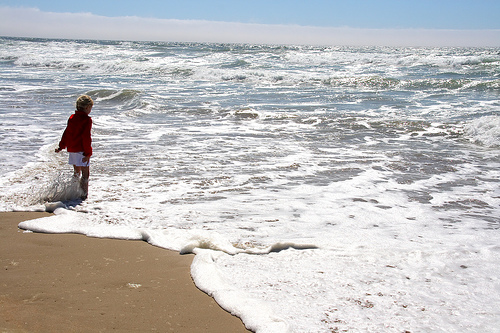

In [124]:
image = captions.loc[captions.Topic == 1, "img_id"].values.tolist()[15]
Image.open(image)

In [123]:
topic_model.get_topic(1)

[('beach', 0.09220602593749763),
 ('ocean', 0.03828323155081248),
 ('sand', 0.037412820861257134),
 ('shore', 0.02613053062260193),
 ('water', 0.023539273315776172),
 ('girl', 0.02122334234875693),
 ('volleyball', 0.01968348294294619),
 ('boy', 0.019102141892818315),
 ('bikini', 0.019075530979010356),
 ('bathe', 0.018877399488222306)]